# Emo-Check: ResNet152 転移学習

画像の「エモさ」を判定するための二値分類モデルをResNet152ベースで学習します。

- **class_0**: Not Emo（エモくない画像）
- **class_1**: Emo（エモい画像）

In [1]:
# 必要なライブラリのインストール
!pip install torch torchvision pillow matplotlib tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# GPU設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

Using device: cpu


In [3]:
# ハイパーパラメータ
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
NUM_CLASSES = 2
IMAGE_SIZE = 224

# データセットパス
DATA_DIR = './dataset'

In [4]:
# データ拡張と前処理
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# データセットの読み込み
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)

# 学習/検証データの分割 (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# 検証データには拡張なしの変換を適用
val_dataset.dataset.transform = val_transforms

print(f'Total images: {len(full_dataset)}')
print(f'Training images: {train_size}')
print(f'Validation images: {val_size}')
print(f'Classes: {full_dataset.classes}')

Total images: 123
Training images: 98
Validation images: 25
Classes: ['class_0', 'class_1']


In [6]:
# DataLoader作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# 入力データのテンソル形状の確認
sample_images, sample_labels = next(iter(train_loader))
print(f'=== 入力データのテンソル形状 ===')
print(f'画像バッチの形状: {sample_images.shape}')
print(f'  - バッチサイズ: {sample_images.shape[0]}')
print(f'  - チャンネル数: {sample_images.shape[1]} (RGB)')
print(f'  - 画像サイズ: {sample_images.shape[2]} x {sample_images.shape[3]} pixels')
print(f'ラベルの形状: {sample_labels.shape}')
print(f'ラベルの例: {sample_labels[:5].tolist()}')

/Users/namboshunsuke/my_projects/Emo-Check/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== 入力データのテンソル形状 ===
画像バッチの形状: torch.Size([32, 3, 224, 224])
  - バッチサイズ: 32
  - チャンネル数: 3 (RGB)
  - 画像サイズ: 224 x 224 pixels
ラベルの形状: torch.Size([32])
ラベルの例: [1, 1, 1, 1, 0]


In [7]:
# ResNet152モデルの構築（転移学習）
model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)

# 最終層を二値分類用に置き換え
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)
print(f'Model loaded and moved to {device}')

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /Users/namboshunsuke/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:25<00:00, 9.35MB/s] 


Model loaded and moved to cpu


In [8]:
# 損失関数と最適化
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# 学習率スケジューラ
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [9]:
# 学習関数
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    return running_loss / len(loader), 100. * correct / total

In [10]:
# 検証関数
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [11]:
# 学習ループ
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    print(f'\n=== Epoch {epoch+1}/{NUM_EPOCHS} ===')
    
    # 学習
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # 検証
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # 学習率更新
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
    
    # ベストモデルの保存
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'resnet152_best.pth')
        print(f'✓ Best model saved! (Val Acc: {val_acc:.2f}%)')


=== Epoch 1/20 ===


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.73s/it]


Train Loss: 0.6147, Train Acc: 68.37%
Val Loss: 0.5020, Val Acc: 76.00%
Learning Rate: 0.000994
✓ Best model saved! (Val Acc: 76.00%)

=== Epoch 2/20 ===


Validation: 100%|██████████| 1/1 [00:18<00:00, 18.17s/it]


Train Loss: 0.2414, Train Acc: 93.88%
Val Loss: 0.4640, Val Acc: 84.00%
Learning Rate: 0.000976
✓ Best model saved! (Val Acc: 84.00%)

=== Epoch 3/20 ===


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.76s/it]


Train Loss: 0.0397, Train Acc: 100.00%
Val Loss: 1.7195, Val Acc: 72.00%
Learning Rate: 0.000946

=== Epoch 4/20 ===


Validation: 100%|██████████| 1/1 [00:16<00:00, 16.36s/it]


Train Loss: 1.0639, Train Acc: 97.96%
Val Loss: 1.0743, Val Acc: 88.00%
Learning Rate: 0.000905
✓ Best model saved! (Val Acc: 88.00%)

=== Epoch 5/20 ===


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.86s/it]


Train Loss: 0.4635, Train Acc: 94.90%
Val Loss: 1.5701, Val Acc: 76.00%
Learning Rate: 0.000854

=== Epoch 6/20 ===


Validation: 100%|██████████| 1/1 [00:16<00:00, 16.64s/it]


Train Loss: 0.3572, Train Acc: 95.92%
Val Loss: 0.9176, Val Acc: 72.00%
Learning Rate: 0.000794

=== Epoch 7/20 ===


Validation: 100%|██████████| 1/1 [00:16<00:00, 16.58s/it]


Train Loss: 0.1376, Train Acc: 97.96%
Val Loss: 0.3732, Val Acc: 84.00%
Learning Rate: 0.000727

=== Epoch 8/20 ===


Validation: 100%|██████████| 1/1 [00:16<00:00, 16.31s/it]


Train Loss: 0.1101, Train Acc: 100.00%
Val Loss: 0.3248, Val Acc: 88.00%
Learning Rate: 0.000655

=== Epoch 9/20 ===


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.99s/it]


Train Loss: 0.0277, Train Acc: 100.00%
Val Loss: 0.2218, Val Acc: 88.00%
Learning Rate: 0.000578

=== Epoch 10/20 ===


Validation: 100%|██████████| 1/1 [00:16<00:00, 16.29s/it]


Train Loss: 0.0340, Train Acc: 100.00%
Val Loss: 0.2239, Val Acc: 92.00%
Learning Rate: 0.000500
✓ Best model saved! (Val Acc: 92.00%)

=== Epoch 11/20 ===


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.69s/it]


Train Loss: 0.0060, Train Acc: 100.00%
Val Loss: 0.2685, Val Acc: 88.00%
Learning Rate: 0.000422

=== Epoch 12/20 ===


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.97s/it]


Train Loss: 0.3720, Train Acc: 98.98%
Val Loss: 0.2902, Val Acc: 84.00%
Learning Rate: 0.000345

=== Epoch 13/20 ===


Validation: 100%|██████████| 1/1 [00:16<00:00, 16.81s/it]


Train Loss: 0.0977, Train Acc: 97.96%
Val Loss: 0.2640, Val Acc: 84.00%
Learning Rate: 0.000273

=== Epoch 14/20 ===


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.95s/it]


Train Loss: 0.0228, Train Acc: 100.00%
Val Loss: 0.2247, Val Acc: 92.00%
Learning Rate: 0.000206

=== Epoch 15/20 ===


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.61s/it]


Train Loss: 0.1700, Train Acc: 98.98%
Val Loss: 0.3054, Val Acc: 92.00%
Learning Rate: 0.000146

=== Epoch 16/20 ===


Validation: 100%|██████████| 1/1 [00:16<00:00, 16.20s/it]


Train Loss: 0.4185, Train Acc: 98.98%
Val Loss: 0.3793, Val Acc: 88.00%
Learning Rate: 0.000095

=== Epoch 17/20 ===


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.96s/it]


Train Loss: 0.0082, Train Acc: 100.00%
Val Loss: 0.2953, Val Acc: 88.00%
Learning Rate: 0.000054

=== Epoch 18/20 ===


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.46s/it]


Train Loss: 0.1619, Train Acc: 98.98%
Val Loss: 0.2939, Val Acc: 88.00%
Learning Rate: 0.000024

=== Epoch 19/20 ===


Validation: 100%|██████████| 1/1 [00:16<00:00, 16.32s/it]


Train Loss: 0.0282, Train Acc: 100.00%
Val Loss: 0.2434, Val Acc: 92.00%
Learning Rate: 0.000006

=== Epoch 20/20 ===


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.99s/it]

Train Loss: 0.0128, Train Acc: 100.00%
Val Loss: 0.2425, Val Acc: 88.00%
Learning Rate: 0.000000


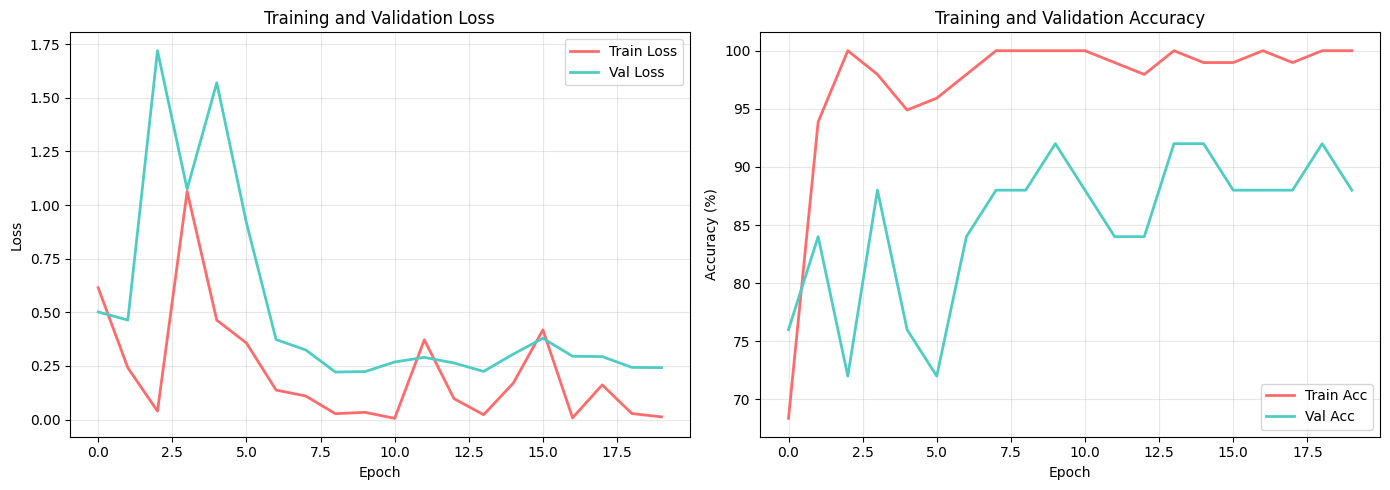


🎉 Training Complete!
Best Validation Accuracy: 92.00%


In [12]:
# 学習曲線のプロット
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', color='#ff6b6b', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', color='#4ecdc4', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Acc', color='#ff6b6b', linewidth=2)
axes[1].plot(val_accs, label='Val Acc', color='#4ecdc4', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet152_training_curves.png', dpi=150)
plt.show()

print(f'\n🎉 Training Complete!')
print(f'Best Validation Accuracy: {best_val_acc:.2f}%')

In [13]:
# 推論用モデルとして保存（state_dictのみ）
# ベストモデルをロード
checkpoint = torch.load('resnet152_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# 推論用に保存
torch.save(model.state_dict(), 'resnet152.pth')
print('✓ Model saved as resnet152.pth')
print(f'  - Best Epoch: {checkpoint["epoch"] + 1}')
print(f'  - Val Accuracy: {checkpoint["val_acc"]:.2f}%')

✓ Model saved as resnet152.pth
  - Best Epoch: 10
  - Val Accuracy: 92.00%


In [14]:
# 推論テスト
from PIL import Image

def predict_emo_score(image_path, model, device):
    """単一画像のエモ度を予測"""
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        emo_score = probabilities[0][1].item()  # class_1 (Emo) の確率
    
    return emo_score * 100  # パーセンテージで返す

# テスト用: データセット内の画像でテスト（存在する場合）
# score = predict_emo_score('path/to/test/image.jpg', model, device)
# print(f'Emo Score: {score:.1f}%')